In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
Path to dataset files: /kaggle/input/default-of-credit-card-clients-dataset
['UCI_Credit_Card.csv']


### load data

In [3]:
df = pd.read_csv(os.path.join(path, 'UCI_Credit_Card.csv'))
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
df.isna().sum().sum()

np.int64(0)

In [6]:
for col in df.columns:
  print(f"{col}: {df[col].unique()}")

ID: [    1     2     3 ... 29998 29999 30000]
LIMIT_BAL: [  20000.  120000.   90000.   50000.  500000.  100000.  140000.  200000.
  260000.  630000.   70000.  250000.  320000.  360000.  180000.  130000.
  450000.   60000.  230000.  160000.  280000.   10000.   40000.  210000.
  150000.  380000.  310000.  400000.   80000.  290000.  340000.  300000.
   30000.  240000.  470000.  480000.  350000.  330000.  110000.  420000.
  170000.  370000.  270000.  220000.  190000.  510000.  460000.  440000.
  410000.  490000.  390000.  580000.  600000.  620000.  610000.  700000.
  670000.  680000.  430000.  550000.  540000. 1000000.  530000.  710000.
  560000.  520000.  750000.  640000.   16000.  570000.  590000.  660000.
  720000.  327680.  740000.  800000.  760000.  690000.  650000.  780000.
  730000.]
SEX: [2 1]
EDUCATION: [2 1 3 5 4 6 0]
MARRIAGE: [1 2 3 0]
AGE: [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66

#### EDA

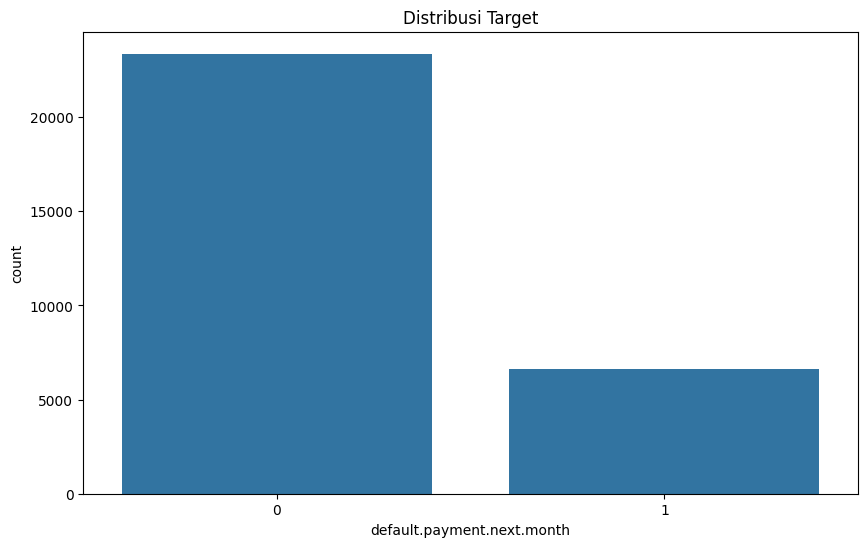

,proportion
default.payment.next.month,
0,0.7788
1,0.2212


In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='default.payment.next.month', data=df)
plt.title('Distribusi Target')
plt.show()

df['default.payment.next.month'].value_counts(normalize=True)

##### numerical vs target

In [8]:
sns.set_style("whitegrid")
sns.set_palette("muted")

feature_pairs = [
    ('AGE', 'LIMIT_BAL'),
    ('BILL_AMT1', 'BILL_AMT2'),
    ('BILL_AMT3', 'BILL_AMT4'),
    ('BILL_AMT5', 'BILL_AMT6'),
    ('PAY_AMT1', 'PAY_AMT2'),
    ('PAY_AMT3', 'PAY_AMT4'),
    ('PAY_AMT5', 'PAY_AMT6')
]

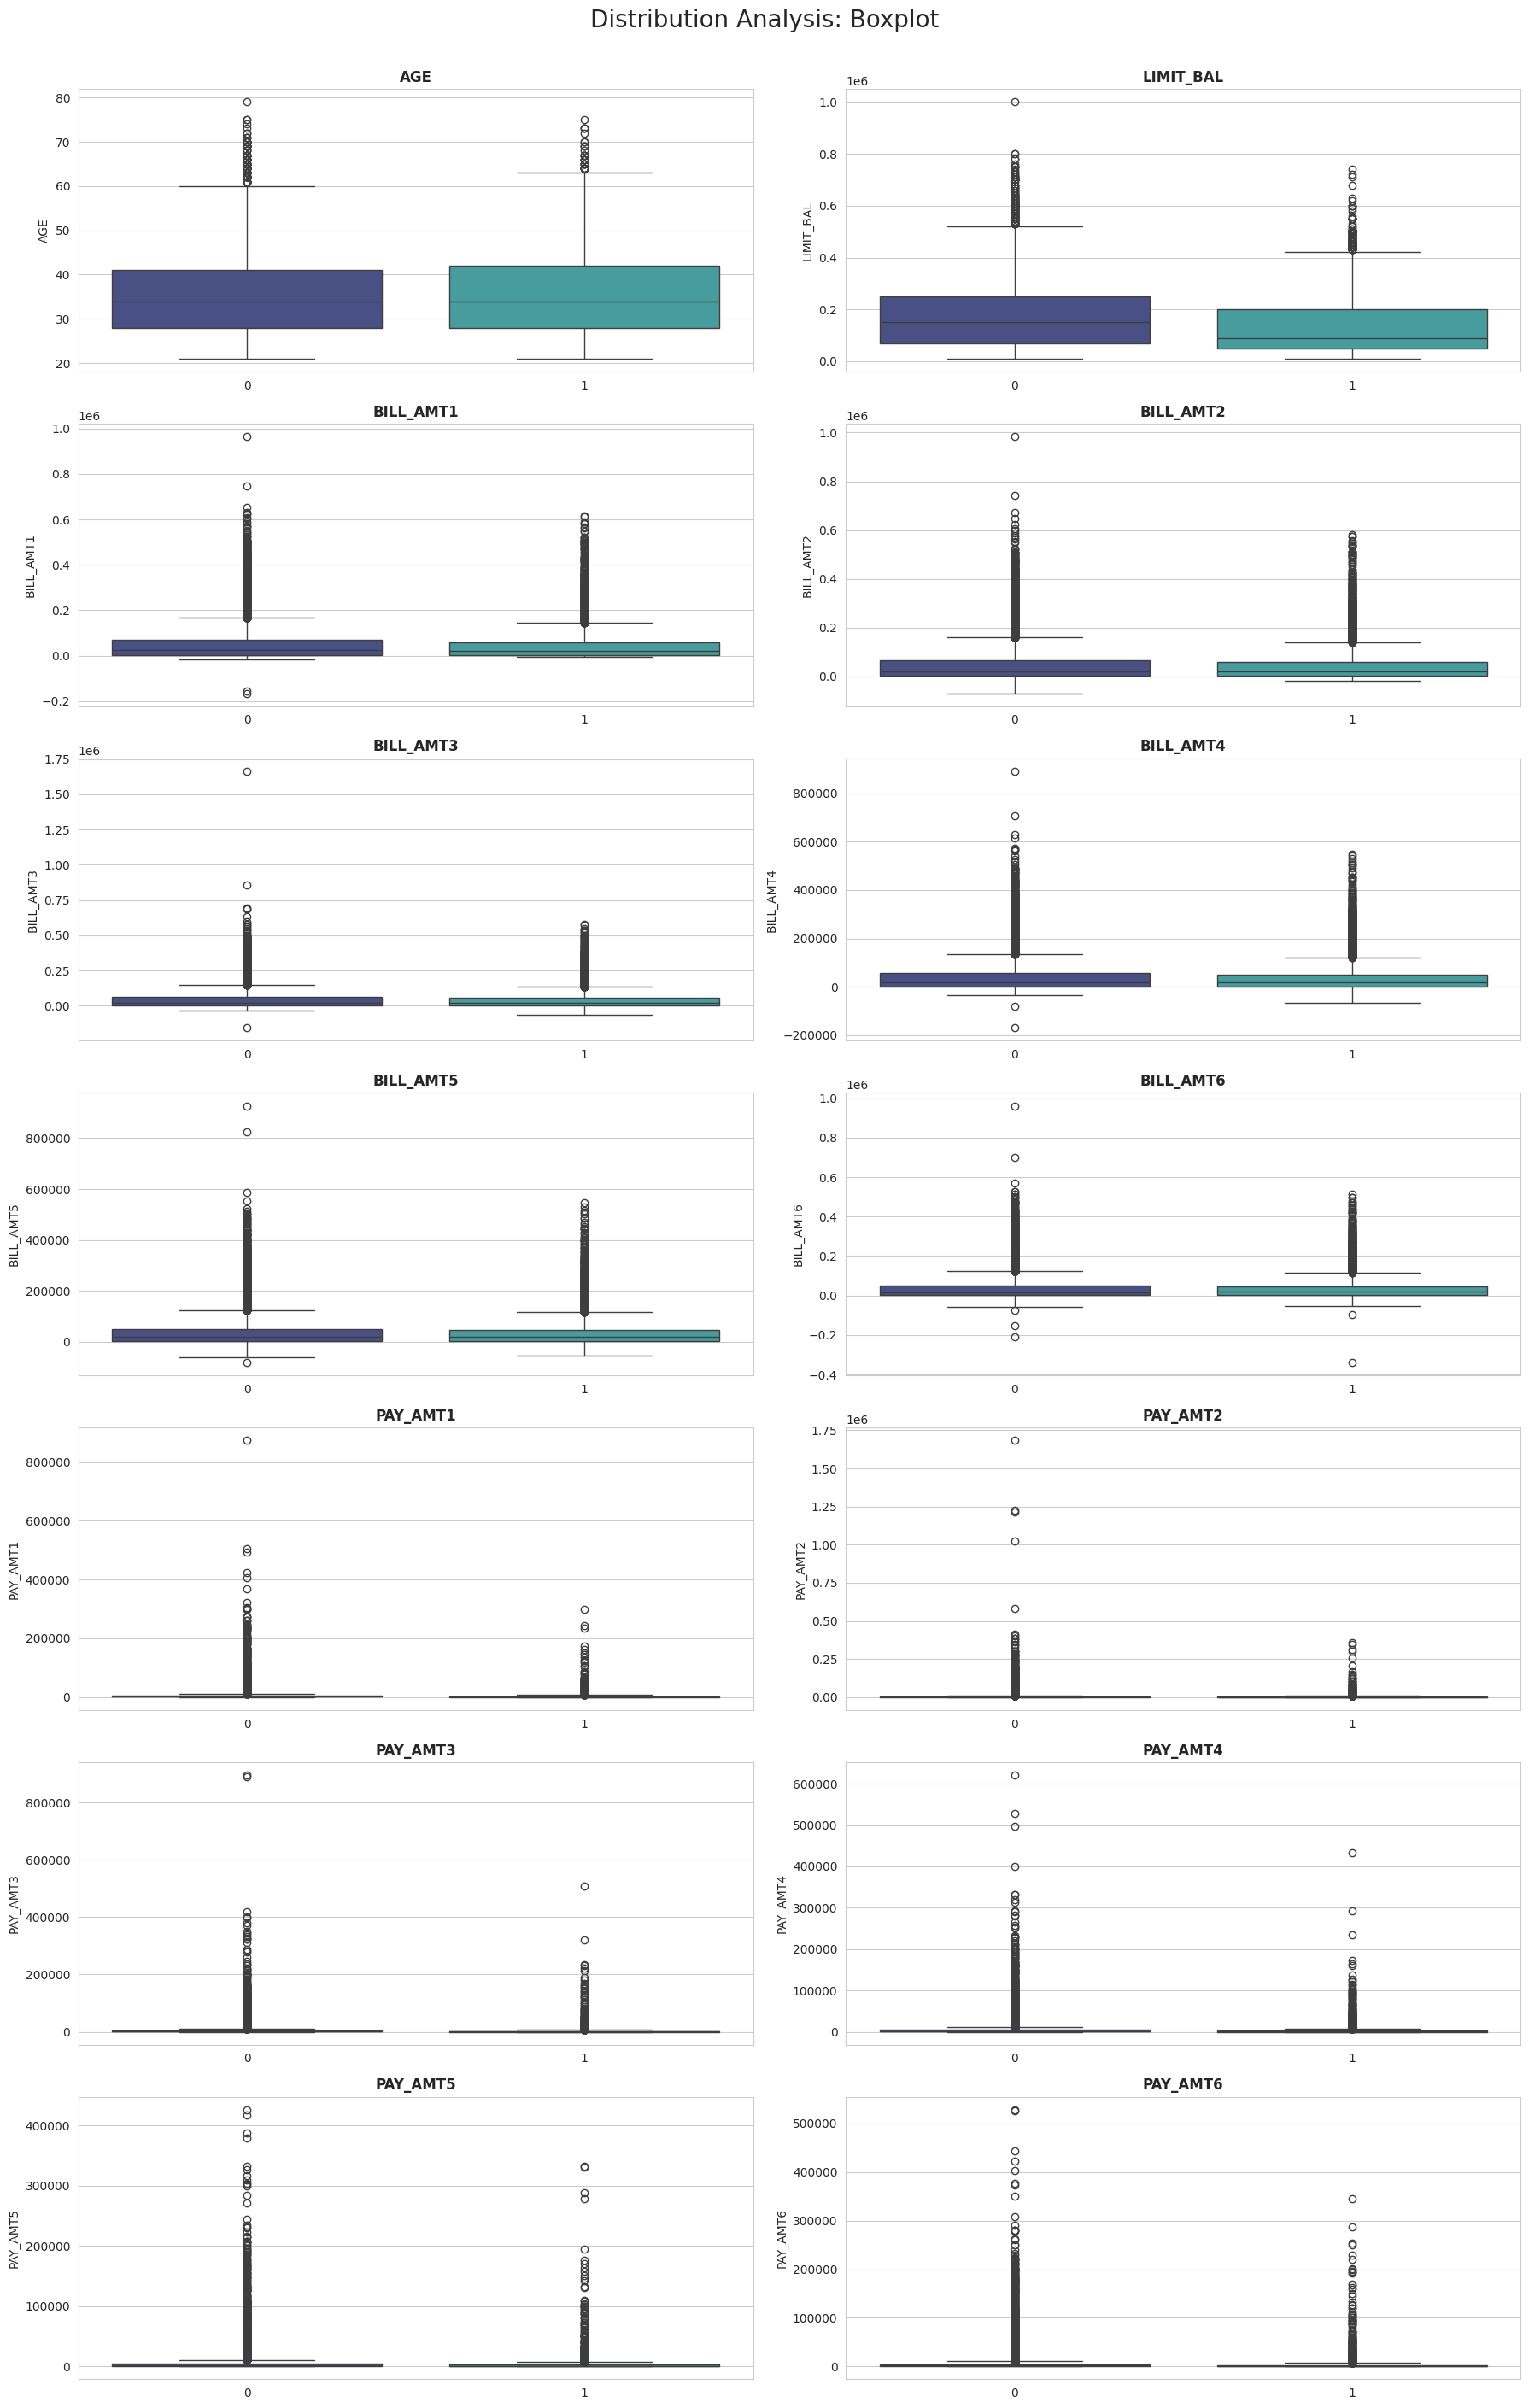

In [9]:
def plot_custom_grid(df, pairs, target_col, kind='box'):
    n_rows = len(pairs)
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))

    plot_names = {'box': 'Boxplot', 'hist': 'Histogram', 'kde': 'KDE Plot'}
    fig.suptitle(f'Distribution Analysis: {plot_names.get(kind, kind)}', fontsize=20, y=1.005)

    for i, (col_left, col_right) in enumerate(pairs):

        ax_l = axes[i, 0]
        if kind == 'box':
            sns.boxplot(data=df, x=target_col, y=col_left, ax=ax_l, palette='mako')
        elif kind == 'hist':
            sns.histplot(data=df, x=col_left, hue=target_col, kde=True, element="step", ax=ax_l, palette='mako')
        elif kind == 'kde':
            sns.kdeplot(data=df, x=col_left, hue=target_col, fill=True, ax=ax_l, palette='mako')

        ax_l.set_title(f'{col_left}', fontsize=12, fontweight='bold')
        ax_l.set_xlabel('')

        ax_r = axes[i, 1]
        if kind == 'box':
            sns.boxplot(data=df, x=target_col, y=col_right, ax=ax_r, palette='mako')
        elif kind == 'hist':
            sns.histplot(data=df, x=col_right, hue=target_col, kde=True, element="step", ax=ax_r, palette='mako')
        elif kind == 'kde':
            sns.kdeplot(data=df, x=col_right, hue=target_col, fill=True, ax=ax_r, palette='mako')

        ax_r.set_title(f'{col_right}', fontsize=12, fontweight='bold')
        ax_r.set_xlabel('')

    plt.tight_layout()
    plt.show()

plot_custom_grid(df, feature_pairs, 'default.payment.next.month', kind='box')

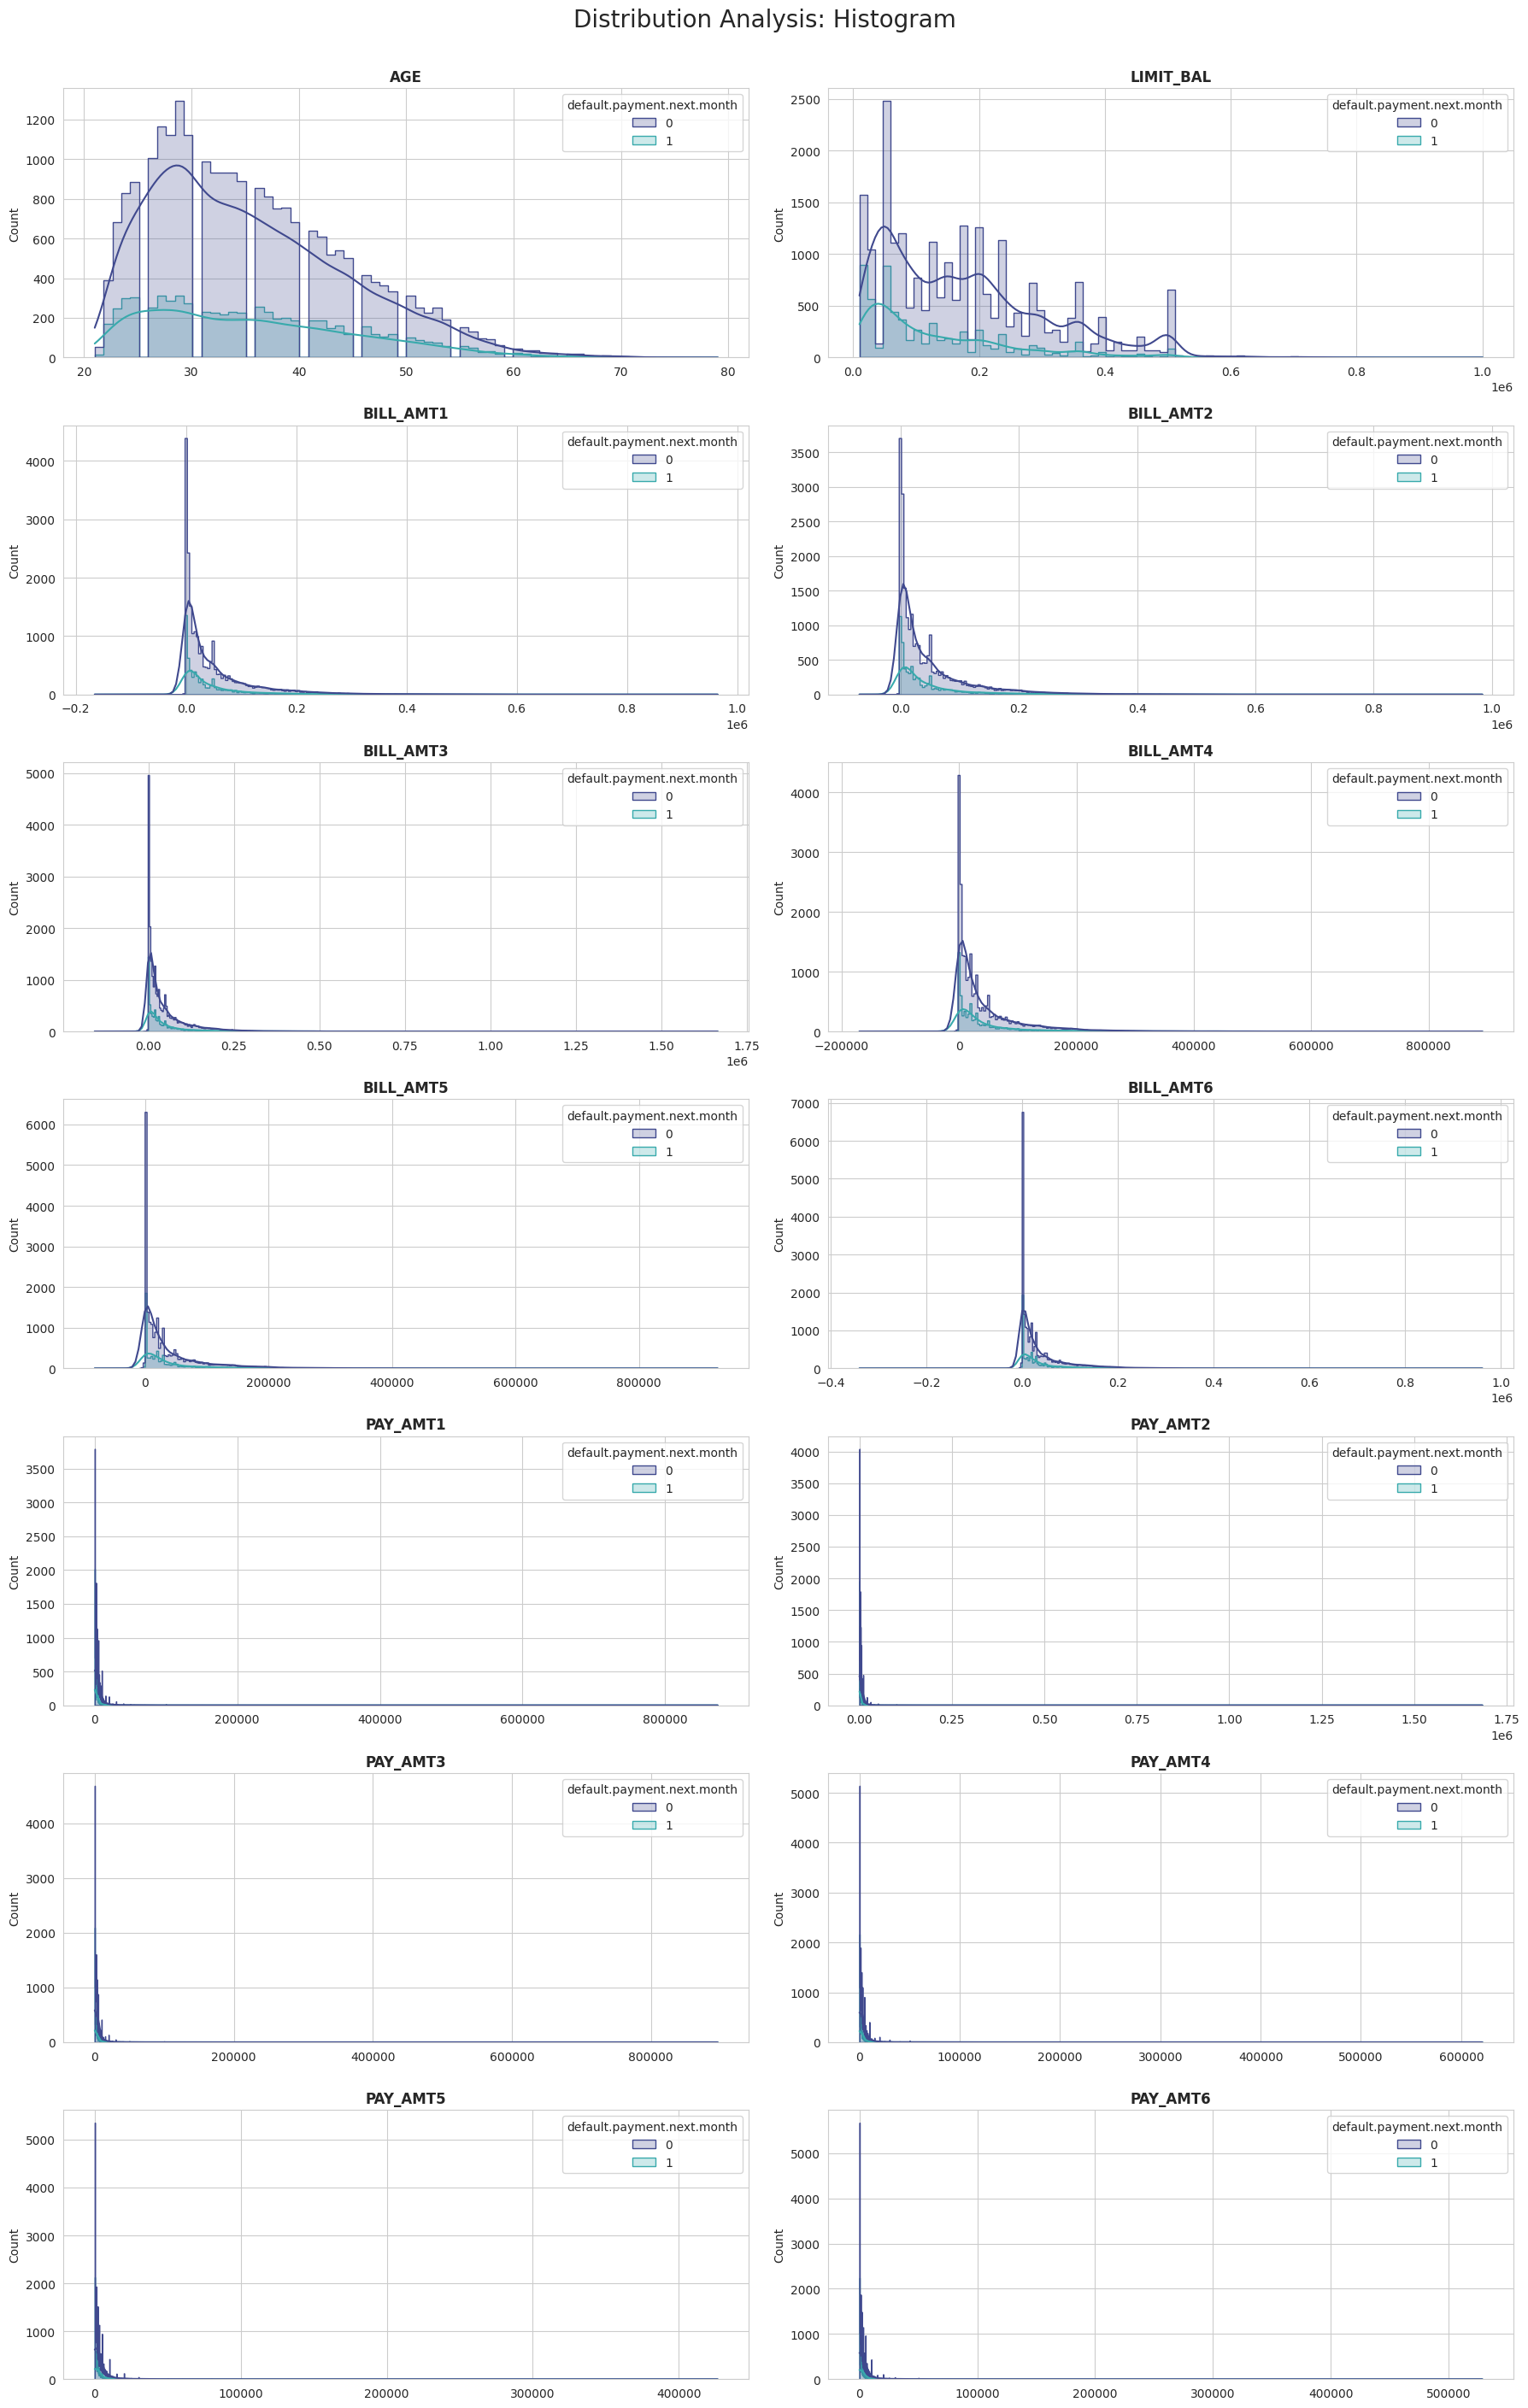

In [10]:
plot_custom_grid(df, feature_pairs, 'default.payment.next.month', kind='hist')

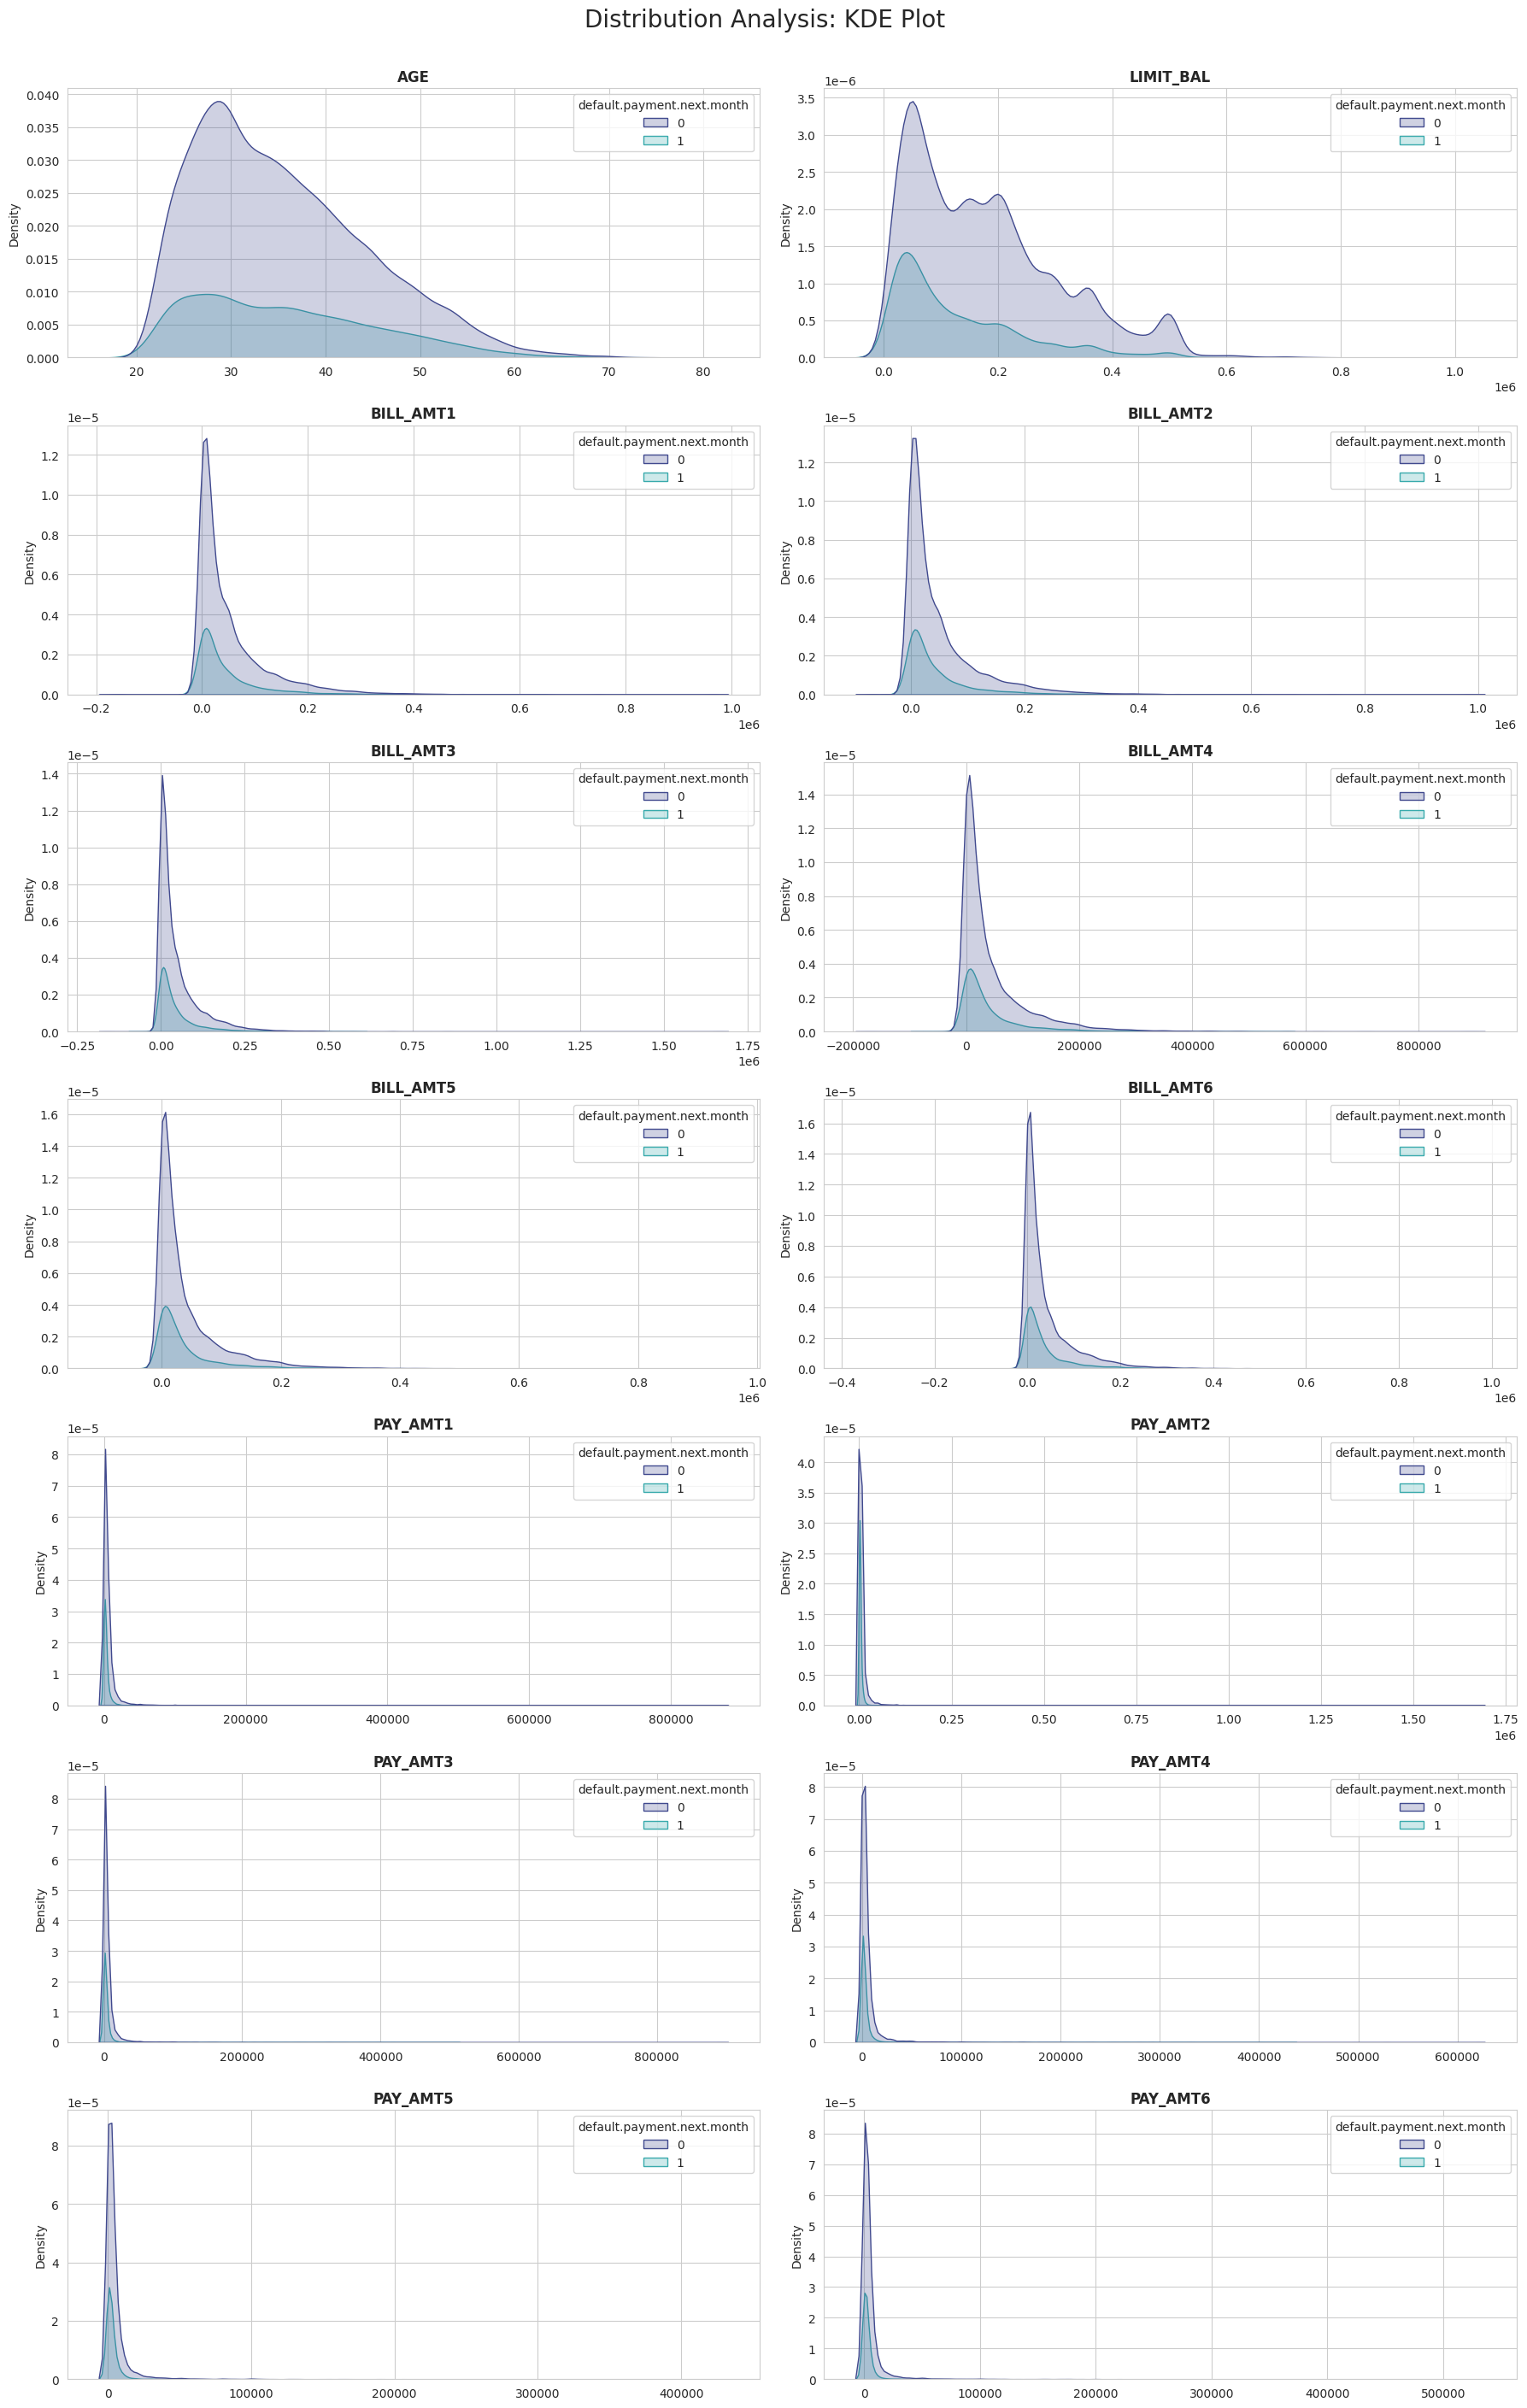

In [11]:
plot_custom_grid(df, feature_pairs, 'default.payment.next.month', kind='kde')

##### kategorikal vs target

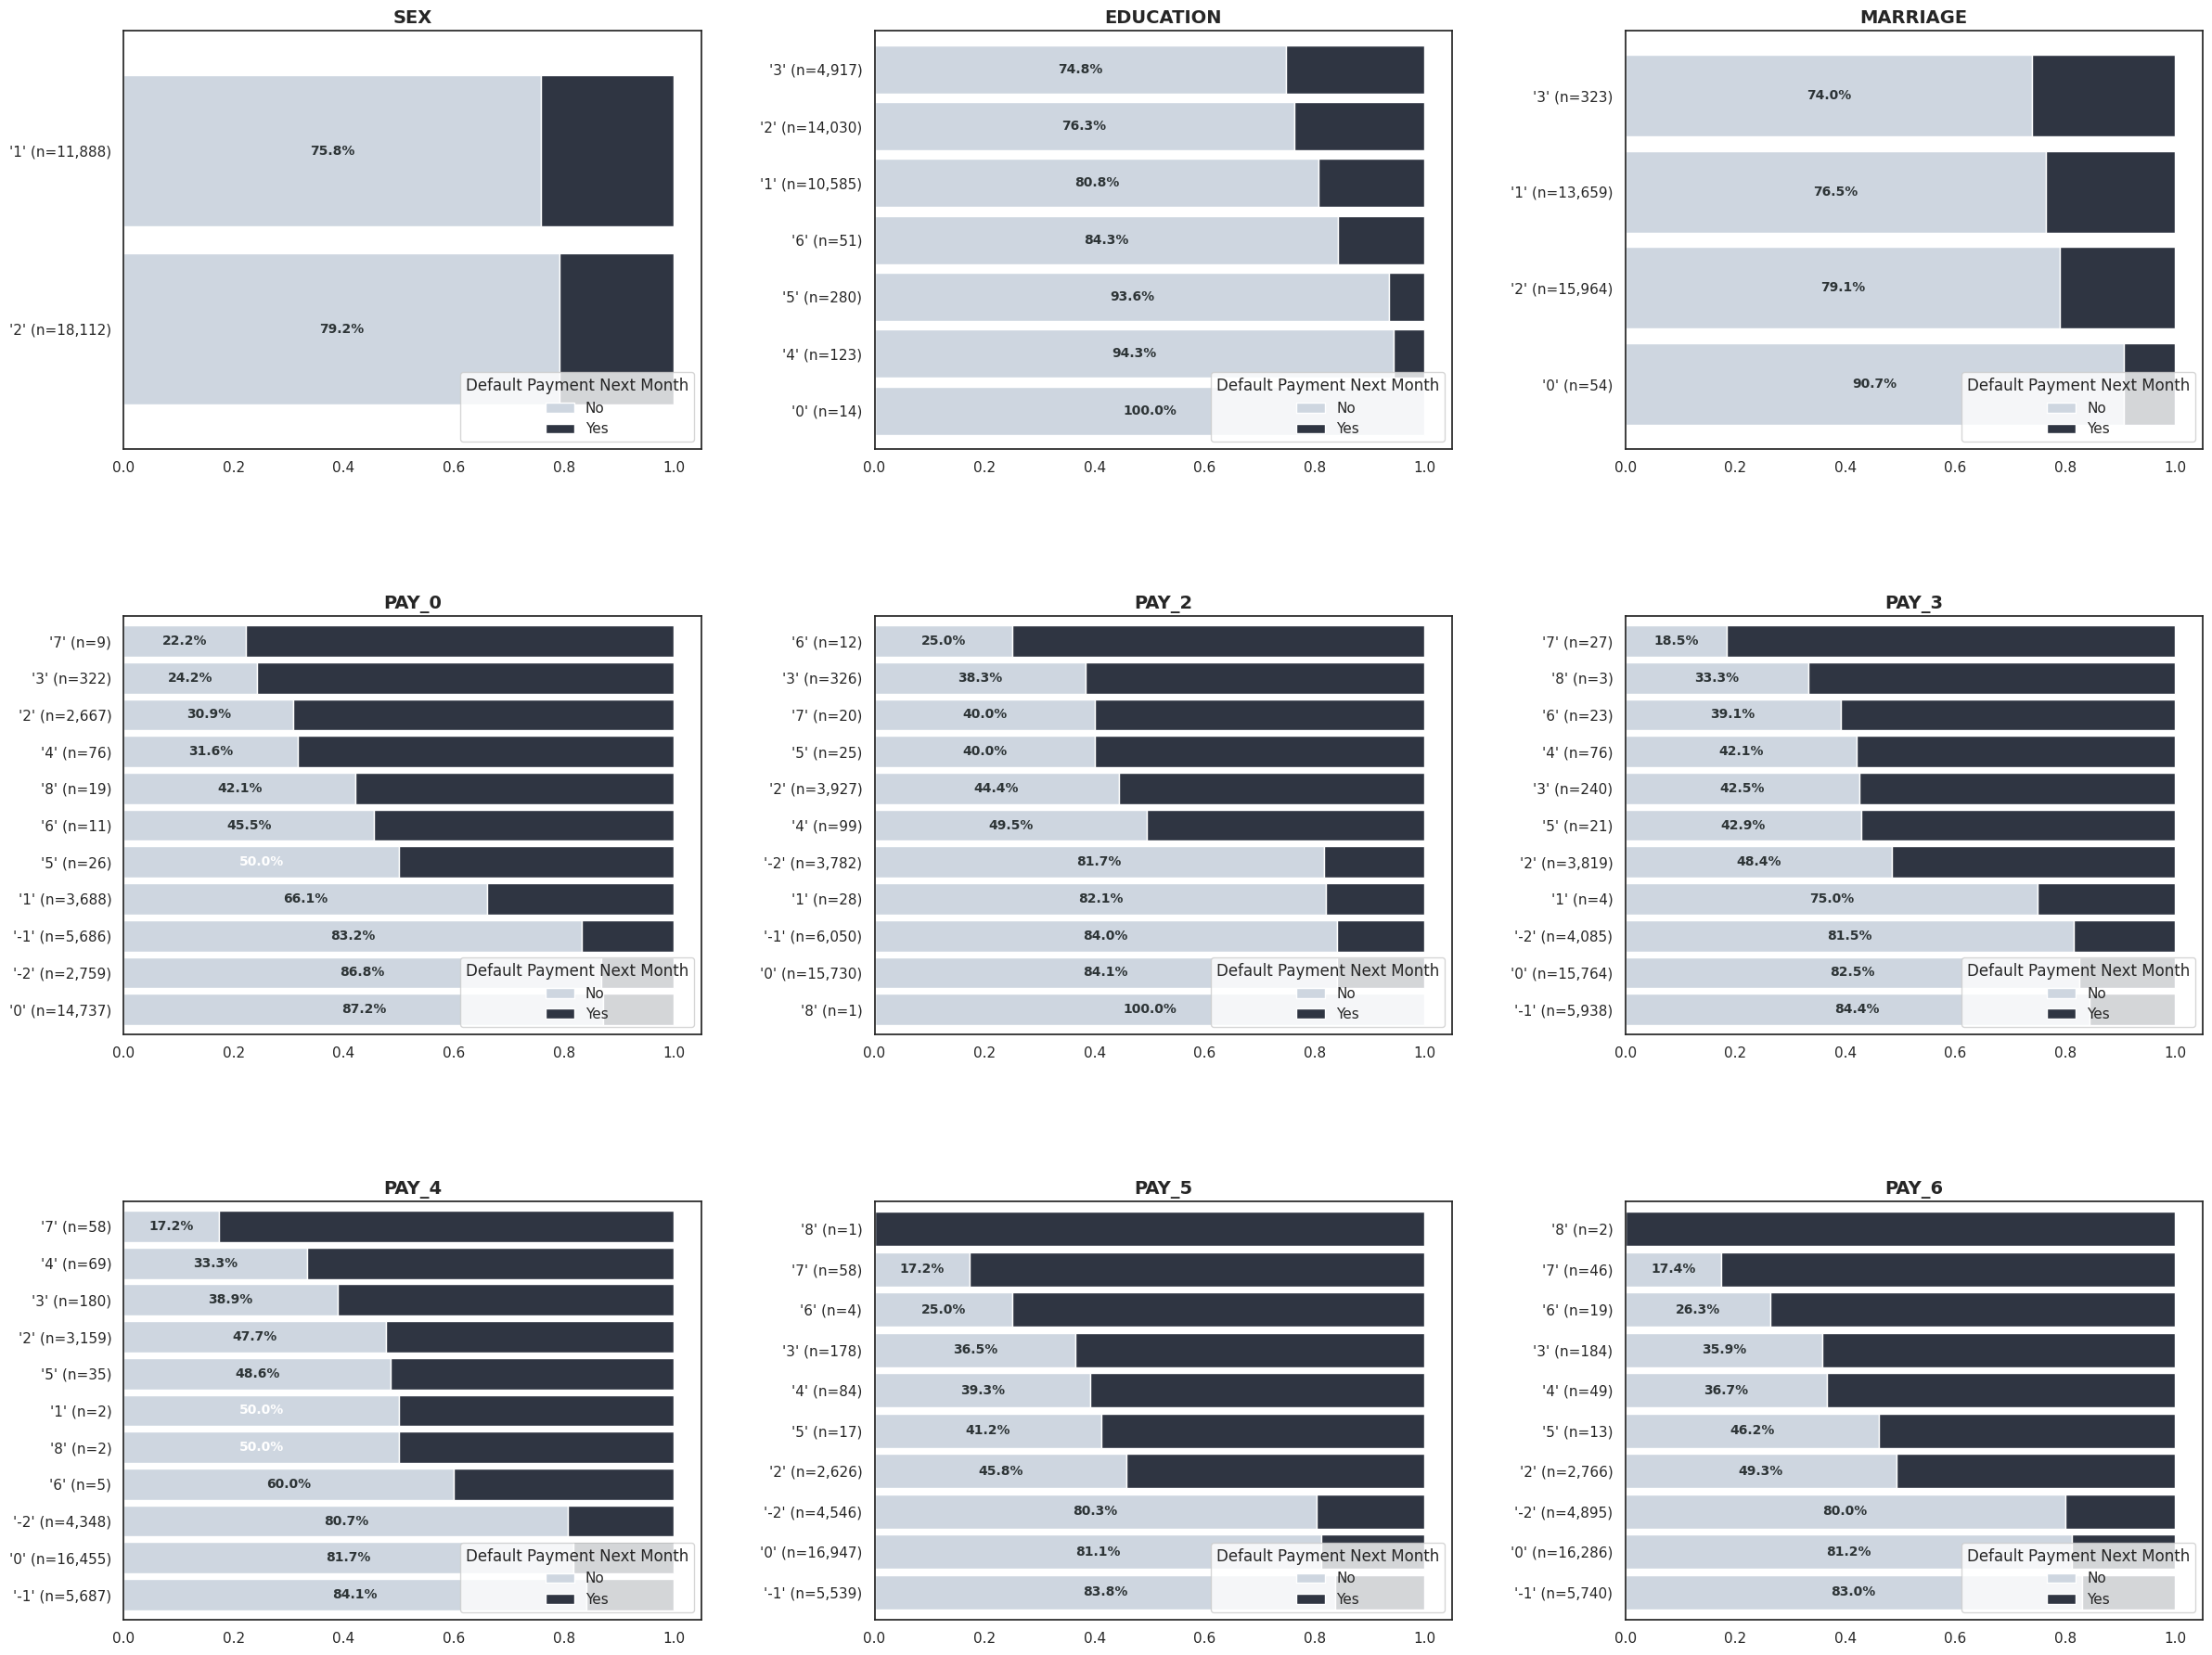

In [12]:
sns.set(style='white', font_scale=1.0)

cat_cols = [
    'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

custom_colors = ['#ced6e0', '#2f3542']

fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    counts = df[col].value_counts()

    cross_tab = pd.crosstab(df[col], df['default.payment.next.month'], normalize='index')

    try:
        target_col = cross_tab.columns[-1]
        cross_tab = cross_tab.sort_values(by=target_col, ascending=True)
    except:
        pass

    new_labels = []
    for cat_name in cross_tab.index:
        count_val = counts[cat_name]
        label_str = f"'{cat_name}' (n={count_val:,})"
        new_labels.append(label_str)

    cross_tab.index = new_labels

    cross_tab.plot(
        kind='barh',
        stacked=True,
        ax=axes[i],
        color=custom_colors,
        width=0.85,
        edgecolor='white'
    )

    axes[i].set_title(f'{col}', fontweight='bold', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].legend(title='Default Payment Next Month', loc='lower right', labels=['No', 'Yes'])

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab.loc[x], [n]):
            if proportion > 0.05:
                text_color = "white" if proportion == cross_tab.loc[x].iloc[-1] else "#2d3436"

                cum_pos = 0
                idx_col = 0
                if proportion == cross_tab.loc[x].iloc[0]:
                    pos_x = proportion / 2
                else:
                    pos_x = cross_tab.loc[x].iloc[0] + (proportion / 2)

                axes[i].text(
                    x=pos_x,
                    y=y_loc,
                    s=f'{np.round(proportion * 100, 1)}%',
                    color=text_color,
                    fontsize=10,
                    fontweight='bold',
                    ha='center', va='center'
                )

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

##### pay n bill time series

In [13]:
pay_cols_chrono = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']

df['num_late_payments'] = (df[pay_cols_chrono] > 0).sum(axis=1)

df['late_ratio'] = df['num_late_payments'] / len(pay_cols_chrono)

df['max_delay'] = df[pay_cols_chrono].max(axis=1)

df['median_delay'] = (
    df[pay_cols_chrono]
    .replace({-1: 0, -2: 0})
    .median(axis=1)
)

df['severe_delay_count'] = (df[pay_cols_chrono] >= 2).sum(axis=1)

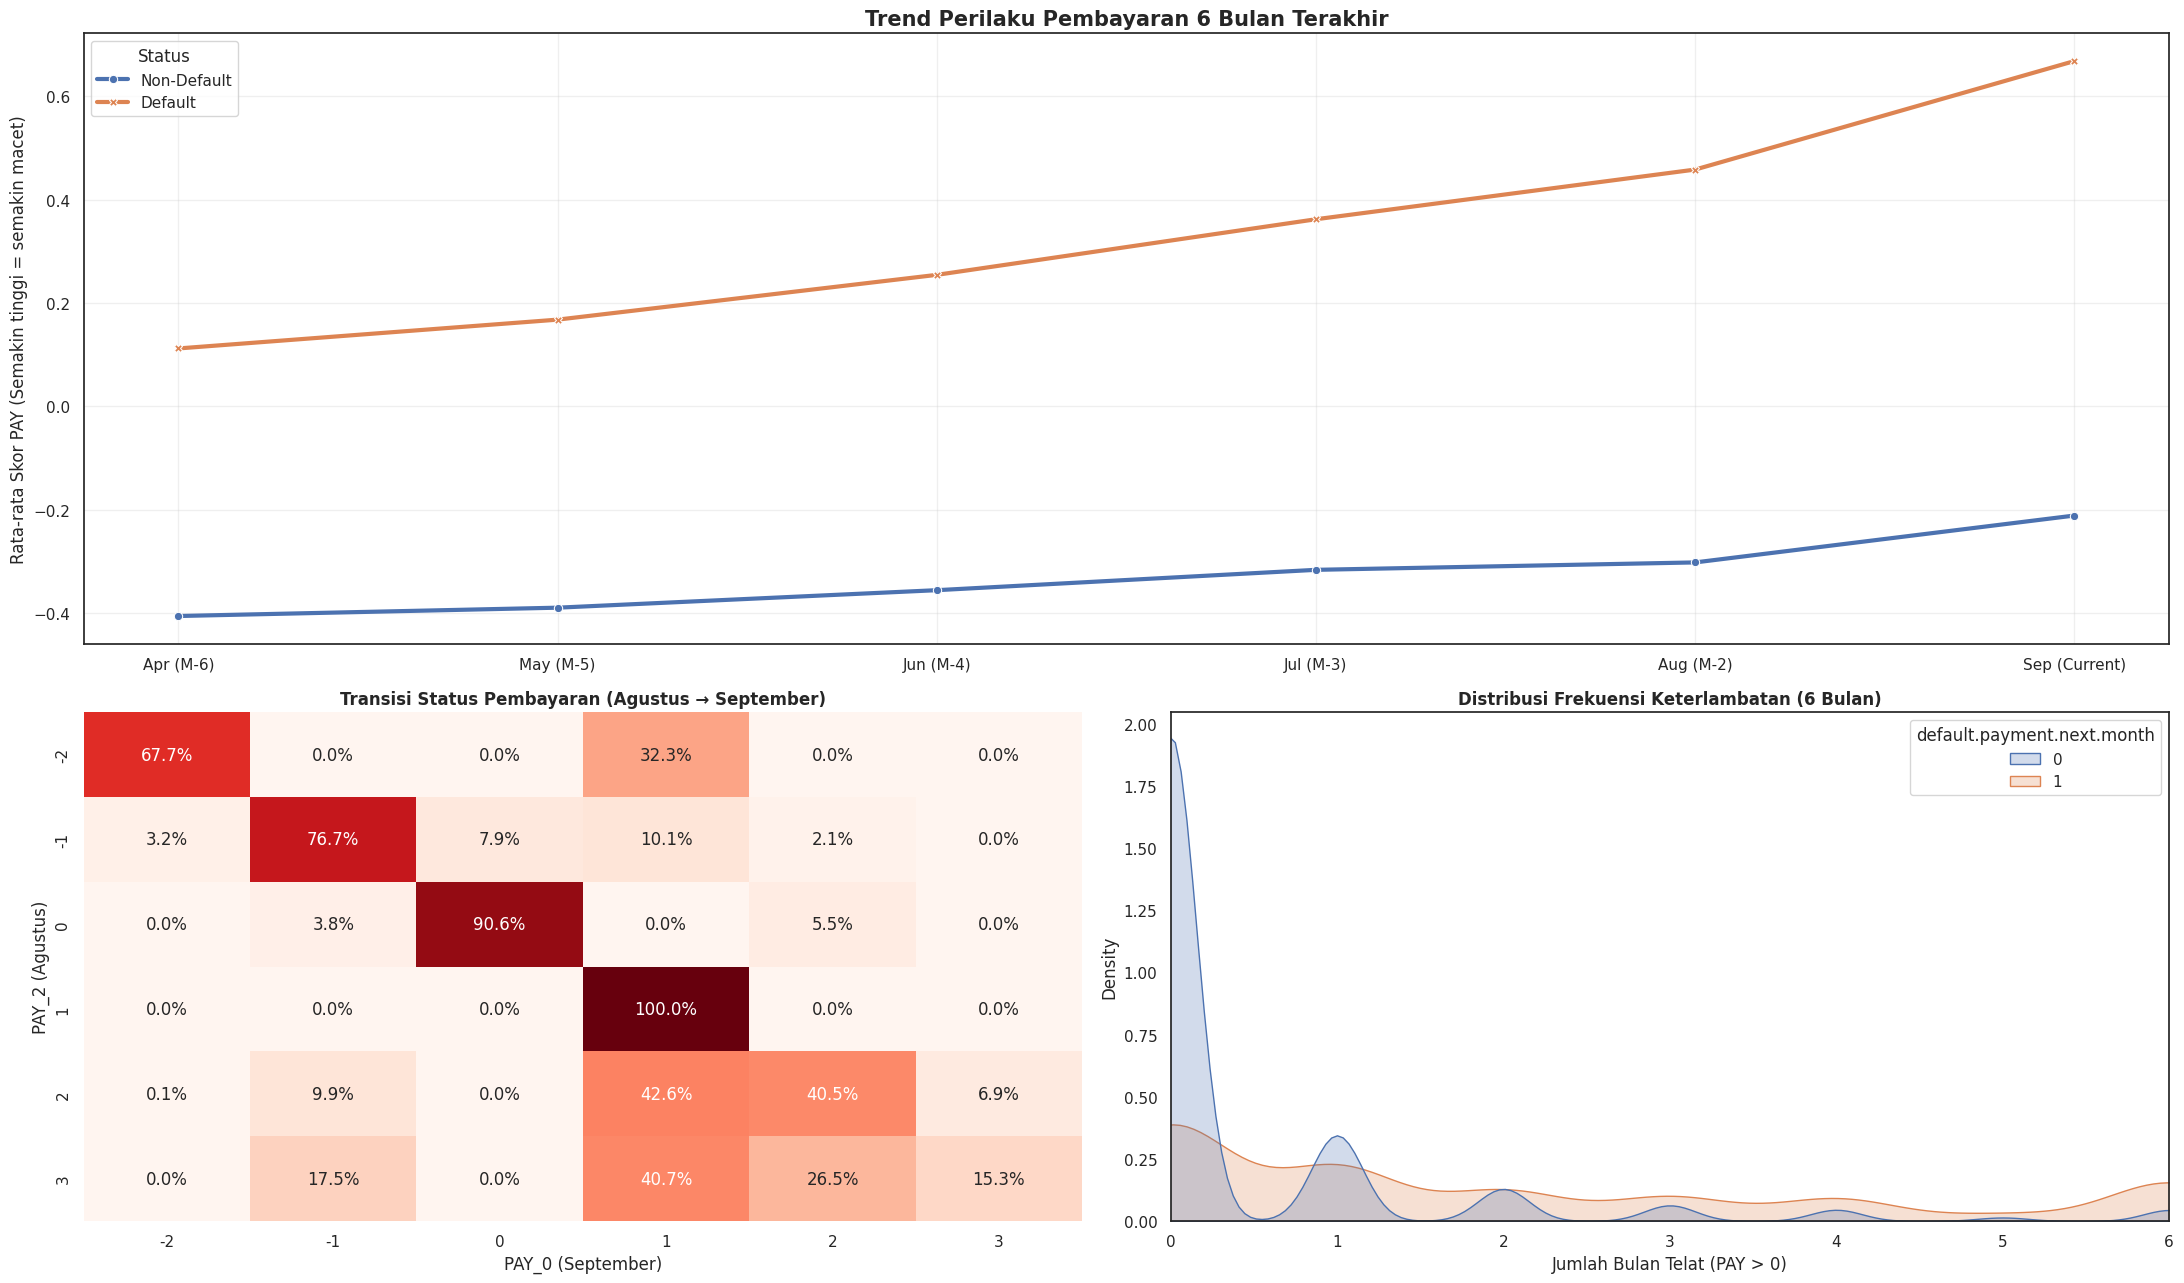

In [14]:
col_names_map = {
    'PAY_6': 'Apr (M-6)', 'PAY_5': 'May (M-5)', 'PAY_4': 'Jun (M-4)',
    'PAY_3': 'Jul (M-3)', 'PAY_2': 'Aug (M-2)', 'PAY_0': 'Sep (Current)'
}

fig = plt.figure(figsize=(22, 13))
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

#1
ax1 = fig.add_subplot(gs[0, :])

trend_data = (
    df.groupby('default.payment.next.month')[pay_cols_chrono]
      .mean()
      .T
      .reset_index()
)

trend_data.columns = ['Month', 'Non-Default', 'Default']
trend_data['Month_Label'] = trend_data['Month'].map(col_names_map)

trend_melt = trend_data.melt(
    id_vars=['Month', 'Month_Label'],
    value_vars=['Non-Default', 'Default'],
    var_name='Status',
    value_name='Avg_PAY_Score'
)

sns.lineplot(
    data=trend_melt,
    x='Month_Label',
    y='Avg_PAY_Score',
    hue='Status',
    style='Status',
    markers=True,
    dashes=False,
    linewidth=3,
    ax=ax1
)

ax1.set_title('Trend Perilaku Pembayaran 6 Bulan Terakhir', fontsize=15, fontweight='bold')
ax1.set_ylabel('Rata-rata Skor PAY (Semakin tinggi = semakin macet)')
ax1.set_xlabel('')
ax1.grid(True, alpha=0.3)


#2
ax2 = fig.add_subplot(gs[1, 0])

filter_range = [-2, -1, 0, 1, 2, 3]
subset_transisi = df[
    df['PAY_2'].isin(filter_range) &
    df['PAY_0'].isin(filter_range)
]

transisi = pd.crosstab(
    subset_transisi['PAY_2'],
    subset_transisi['PAY_0'],
    normalize='index'
)

sns.heatmap(
    transisi,
    annot=True,
    fmt='.1%',
    cmap='Reds',
    cbar=False,
    ax=ax2
)

ax2.set_title('Transisi Status Pembayaran (Agustus → September)', fontweight='bold')
ax2.set_ylabel('PAY_2 (Agustus)')
ax2.set_xlabel('PAY_0 (September)')

#3
ax3 = fig.add_subplot(gs[1, 1])

sns.kdeplot(
    data=df,
    x='num_late_payments',
    hue='default.payment.next.month',
    fill=True,
    common_norm=False,
    ax=ax3,
    warn_singular=False
)

ax3.set_title('Distribusi Frekuensi Keterlambatan (6 Bulan)', fontweight='bold')
ax3.set_xlabel('Jumlah Bulan Telat (PAY > 0)')
ax3.set_xlim(0, 6)

plt.tight_layout()
plt.show()

##### corr heatmap

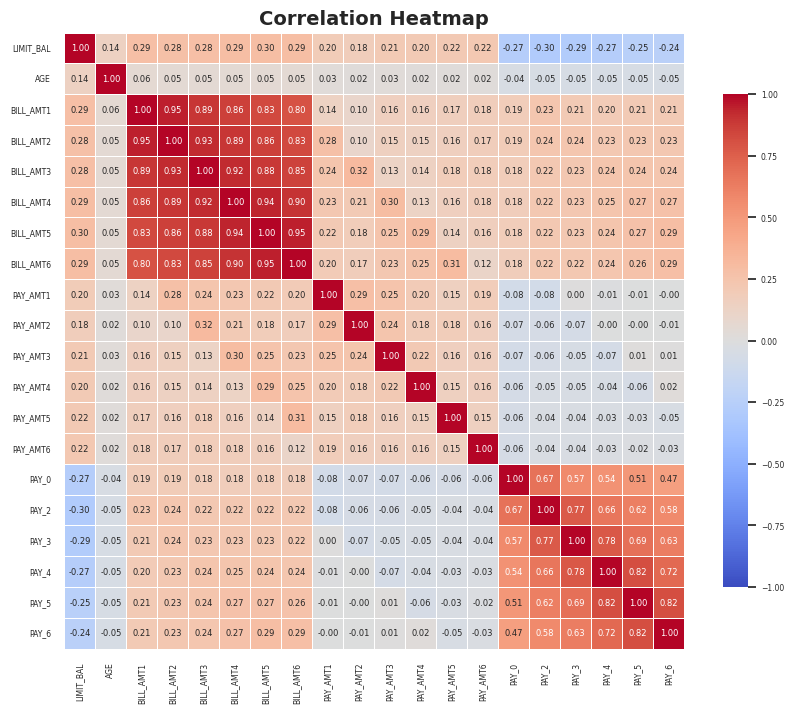

In [15]:
sns.set(style='white', font_scale=.5)

corr_features = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

df_corr = df[corr_features]

plt.figure(figsize=(10, 8))
correlation_matrix = df_corr[corr_features].corr(method='pearson')

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1, vmax=1,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.show()

#### Feature Enginerring

##### drop id

In [16]:
df = df.drop(columns=["ID"])

##### replace data diluar deskripsi dataset

In [17]:
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 'Unknown')
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 'Unknown')

In [18]:
for col in df.columns:
  print(f"{col}: {df[col].unique()}")

LIMIT_BAL: [  20000.  120000.   90000.   50000.  500000.  100000.  140000.  200000.
  260000.  630000.   70000.  250000.  320000.  360000.  180000.  130000.
  450000.   60000.  230000.  160000.  280000.   10000.   40000.  210000.
  150000.  380000.  310000.  400000.   80000.  290000.  340000.  300000.
   30000.  240000.  470000.  480000.  350000.  330000.  110000.  420000.
  170000.  370000.  270000.  220000.  190000.  510000.  460000.  440000.
  410000.  490000.  390000.  580000.  600000.  620000.  610000.  700000.
  670000.  680000.  430000.  550000.  540000. 1000000.  530000.  710000.
  560000.  520000.  750000.  640000.   16000.  570000.  590000.  660000.
  720000.  327680.  740000.  800000.  760000.  690000.  650000.  780000.
  730000.]
SEX: [2 1]
EDUCATION: [2 1 3 'Unknown' 4]
MARRIAGE: [1 2 3 'Unknown']
AGE: [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
P

#### Modelling

##### split data

In [19]:
X = df.drop(columns=['default.payment.next.month'])
y = df['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

##### feature typing

In [20]:
numerical_features = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_0', 'PAY_2', 'PAY_3',
    'PAY_4', 'PAY_5', 'PAY_6'
]

for col in categorical_features:
  df[col] = df[col].astype(str)

##### pipeline preprocessing

In [21]:
categorical_cast = FunctionTransformer(
    lambda X: X.astype(str),
    feature_names_out="one-to-one"
)

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat',
         Pipeline([
             ('cast', categorical_cast),
             ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
         ]),
         categorical_features
        )
    ]
)

##### modelling

In [23]:
log_a = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42
        ))
])

log_b = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42))
])

eval pred

In [24]:
scoring_metrics =  [
    'precision',
    'recall',
    'f1',
    'average_precision'
]

crossval = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in [('log_a', log_a), ('log_b', log_b)]:
    cv_results = cross_validate(model, X_train, y_train, cv=crossval, scoring=scoring_metrics)

    results[name] = {
        'Mean Precision': f"{cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}",
        'Mean Recall': f"{cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}",
        'Mean F1': f"{cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}",
        'Mean PR-AUC': f"{cv_results['test_average_precision'].mean():.4f} ± {cv_results['test_average_precision'].std():.4f}"
    }

In [25]:
results_df = pd.DataFrame(results).T
print("logistics non classweight v logistics classweight (5-Fold CV)")
print(f"\n{results_df}")

logistics non classweight v logistics classweight (5-Fold CV)

        Mean Precision      Mean Recall          Mean F1      Mean PR-AUC
log_a  0.6792 ± 0.0158  0.3583 ± 0.0083  0.4689 ± 0.0052  0.5434 ± 0.0117
log_b  0.4931 ± 0.0090  0.5801 ± 0.0116  0.5330 ± 0.0096  0.5426 ± 0.0122


##### log non balance

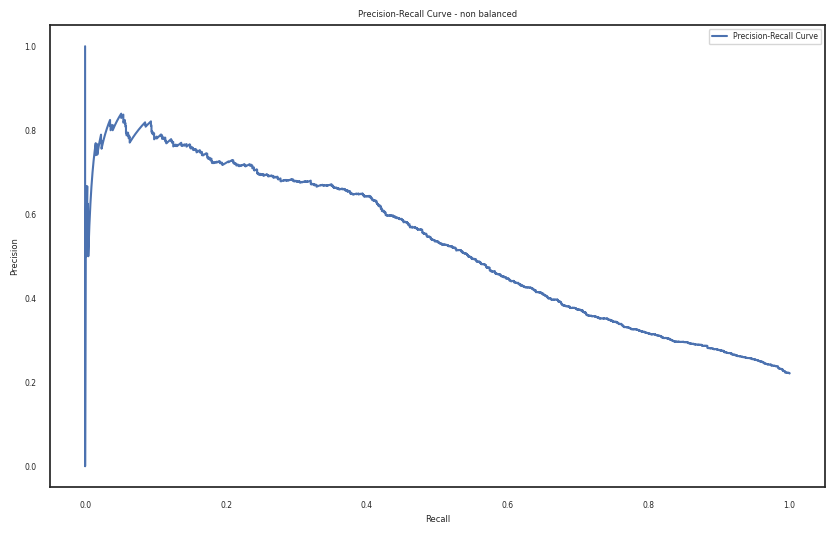

In [26]:
log_a.fit(X_train, y_train)
y_pred = log_a.predict(X_test)
y_proba_a = log_a.predict_proba(X_test)[:, 1]

precision, recall, threshold = precision_recall_curve(y_test, y_proba_a)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - non balanced')
plt.legend()
plt.show()

##### log with balance

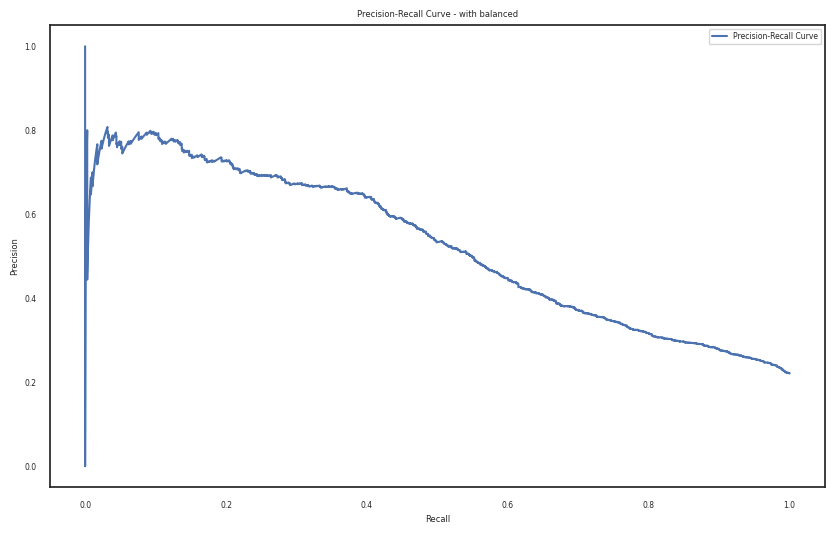

In [27]:
log_b.fit(X_train, y_train)
y_pred = log_b.predict(X_test)
y_proba_b = log_b.predict_proba(X_test)[:, 1]

precision, recall, threshold = precision_recall_curve(y_test, y_proba_b)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - with balanced')
plt.legend()
plt.show()

#### threshold

###### by f1

In [28]:
def find_best_f1_threshold(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1)
    return {
        'threshold': thresholds[max(best_idx - 1, 0)],
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'f1': f1[best_idx]
    }

f1_a = find_best_f1_threshold(y_test, y_proba_a)
f1_b = find_best_f1_threshold(y_test, y_proba_b)

f1_a, f1_b

({'threshold': np.float64(0.24508061528124764),
  'precision': np.float64(0.5145348837209303),
  'recall': np.float64(0.53353428786737),
  'f1': np.float64(0.5238623750887511)},
 {'threshold': np.float64(0.5262600591711928),
  'precision': np.float64(0.5114122681883024),
  'recall': np.float64(0.5403165033911078),
  'f1': np.float64(0.5254672040541051)})

###### by recall

In [29]:
def threshold_by_recall(y_true, y_scores, min_recall=0.70):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    idx = np.where(recall >= min_recall)[0][0]
    return {
        'threshold': thresholds[idx],
        'precision': precision[idx],
        'recall': recall[idx]
    }

recall_a = threshold_by_recall(y_test, y_proba_a, min_recall=0.70)
recall_b = threshold_by_recall(y_test, y_proba_b, min_recall=0.70)

print(recall_a)
print(recall_b)

{'threshold': np.float64(4.143385152584013e-08), 'precision': np.float64(0.22116666666666668), 'recall': np.float64(1.0)}
{'threshold': np.float64(9.489124541335023e-07), 'precision': np.float64(0.22116666666666668), 'recall': np.float64(1.0)}


eval threshold

In [30]:
def eval_threshold(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    return {
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'report': classification_report(y_true, y_pred, digits=3)
    }

cm_f1_a = eval_threshold(y_test, y_proba_a, f1_a['threshold'])
cm_f1_b = eval_threshold(y_test, y_proba_b, f1_b['threshold'])

cm_rec_a = eval_threshold(y_test, y_proba_a, recall_a['threshold'])
cm_rec_b = eval_threshold(y_test, y_proba_b, recall_b['threshold'])

print(cm_f1_a['report'])
print(cm_f1_b['report'])
print(cm_rec_a['report'])
print(cm_rec_b['report'])

              precision    recall  f1-score   support

           0      0.866     0.857     0.861      4673
           1      0.514     0.534     0.524      1327

    accuracy                          0.785      6000
   macro avg      0.690     0.695     0.693      6000
weighted avg      0.788     0.785     0.787      6000

              precision    recall  f1-score   support

           0      0.867     0.853     0.860      4673
           1      0.511     0.540     0.525      1327

    accuracy                          0.784      6000
   macro avg      0.689     0.697     0.693      6000
weighted avg      0.789     0.784     0.786      6000

              precision    recall  f1-score   support

           0      0.000     0.000     0.000      4673
           1      0.221     1.000     0.362      1327

    accuracy                          0.221      6000
   macro avg      0.111     0.500     0.181      6000
weighted avg      0.049     0.221     0.080      6000

              preci

In [31]:
summary = pd.DataFrame([
    ['log_a', 'F1-based', f1_a['threshold'], f1_a['precision'], f1_a['recall'], f1_a['f1']],
    ['log_a', 'Recall-based', recall_a['threshold'], recall_a['precision'], recall_a['recall'], None],
    ['log_b', 'F1-based', f1_b['threshold'], f1_b['precision'], f1_b['recall'], f1_b['f1']],
    ['log_b', 'Recall-based', recall_b['threshold'], recall_b['precision'], recall_b['recall'], None],
], columns=['Model', 'Strategy', 'Threshold', 'Precision', 'Recall', 'F1'])

summary

,Model,Strategy,Threshold,Precision,Recall,F1
0,log_a,F1-based,2.450806e-01,0.514535,0.533534,0.523862
1,log_a,Recall-based,4.143385e-08,0.221167,1.000000,NaN
2,log_b,F1-based,5.262601e-01,0.511412,0.540317,0.525467
3,log_b,Recall-based,9.489125e-07,0.221167,1.000000,NaN
